In [1]:
import torch

import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
from torch import nn, optim

In [2]:
rcParams['figure.figsize'] = 14, 10
register_matplotlib_converters()

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

In [84]:
df = pd.read_csv('https://api.covid19india.org/csv/latest/state_wise_daily.csv')
df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,14-Mar-20,Recovered,9,0,0,0,0,0,0,0,...,0,1,0,0,0,0,4,0,0,0
2,14-Mar-20,Deceased,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
4,15-Mar-20,Recovered,4,0,0,0,0,0,0,0,...,0,2,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,21-Jun-20,Recovered,9075,2,196,6,202,264,0,53,...,22,323,4,1438,225,79,626,50,432,0
299,21-Jun-20,Deceased,426,0,5,0,0,2,0,0,...,1,12,0,53,7,0,21,0,15,0
300,22-Jun-20,Confirmed,13560,0,443,9,267,228,5,47,...,161,302,0,2710,872,16,591,58,413,-1295
301,22-Jun-20,Recovered,10879,0,128,1,161,136,6,66,...,125,313,4,1358,274,23,606,21,390,0


In [85]:
confirmed_df = df[df.Status == "Confirmed"]
confirmed_df = confirmed_df.reset_index(drop = True)
confirmed_df

,Date,Status,TT,AN,AP,AR,AS,BR,CH,CT,...,PB,RJ,SK,TN,TG,TR,UP,UT,WB,UN
0,14-Mar-20,Confirmed,81,0,1,0,0,0,0,0,...,1,3,0,1,1,0,12,0,0,0
1,15-Mar-20,Confirmed,27,0,0,0,0,0,0,0,...,0,1,0,0,2,0,1,0,0,0
2,16-Mar-20,Confirmed,15,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,1,0,0
3,17-Mar-20,Confirmed,11,0,0,0,0,0,0,0,...,0,0,0,0,1,0,2,0,1,0
4,18-Mar-20,Confirmed,37,0,0,0,0,0,0,0,...,1,3,0,1,8,0,2,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,18-Jun-20,Confirmed,13829,1,425,0,209,100,4,82,...,118,315,0,2141,352,21,604,80,435,430
97,19-Jun-20,Confirmed,14638,2,465,32,0,250,7,72,...,217,299,0,2115,499,27,809,74,355,224
98,20-Jun-20,Confirmed,15918,0,491,0,249,213,23,116,...,120,381,0,2396,546,8,541,124,441,338
99,21-Jun-20,Confirmed,15150,1,477,4,331,162,2,121,...,122,393,8,2532,730,35,596,43,414,-138


In [86]:
recovered_df = df[df.Status == "Recovered"]
deceased_df = df[df.Status == "Deceased"]

In [87]:
confirmed_df = confirmed_df.drop("Status", axis = 1)


In [169]:
daily_cases = confirmed_df.iloc[0:,1]
daily_cases.index = confirmed_df['Date']
daily_cases.head()


Date
14-Mar-20    81
15-Mar-20    27
16-Mar-20    15
17-Mar-20    11
18-Mar-20    37
Name: TT, dtype: int64

(101,)

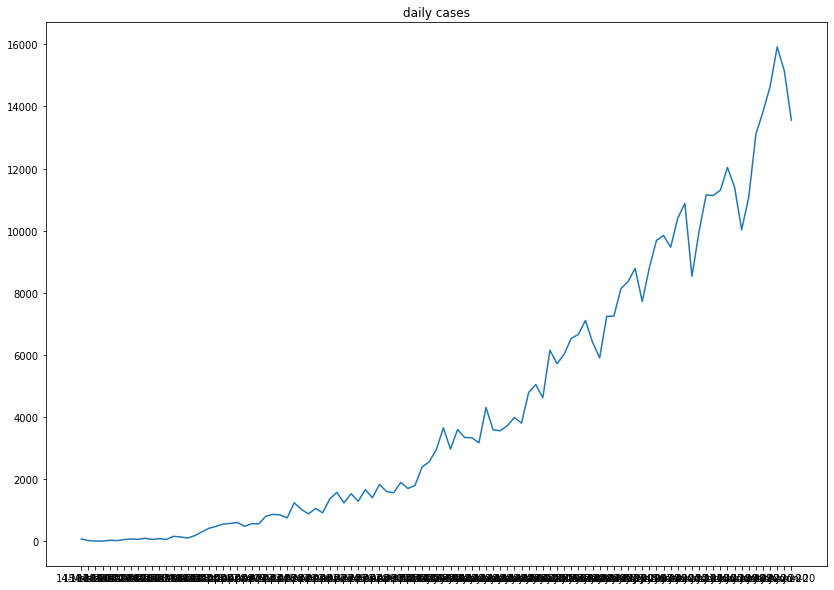

In [170]:
plt.plot(daily_cases)
plt.title("daily cases");
daily_cases.shape

In [211]:
test_data_size = 40

train_data = daily_cases[:-test_data_size]
test_data = daily_cases[-test_data_size:]
print(train_data.head())
print(test_data.head())

Date
14-Mar-20    81
15-Mar-20    27
16-Mar-20    15
17-Mar-20    11
18-Mar-20    37
Name: TT, dtype: int64
Date
14-May-20    3991
15-May-20    3808
16-May-20    4794
17-May-20    5049
18-May-20    4628
Name: TT, dtype: int64


In [212]:
scaler = MinMaxScaler()
scaler = scaler.fit(np.expand_dims(train_data, axis=1))
train_data = scaler.transform(np.expand_dims(train_data, axis=1))
test_data = scaler.transform(np.expand_dims(test_data, axis=1))
print(train_data[:5])
print(test_data[:5])

[[0.01627907]
 [0.00372093]
 [0.00093023]
 [0.        ]
 [0.00604651]]
[[0.9255814 ]
 [0.88302326]
 [1.11232558]
 [1.17162791]
 [1.07372093]]


In [213]:
def create_sequences(data, seq_length):
    xs = []
    ys = []

    for i in range(len(data)-seq_length-1):
        x = data[i:(i+seq_length)]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)

    return np.array(xs), np.array(ys)

In [174]:
seq_length = 5
X_train, y_train = create_sequences(train_data, seq_length)
X_test, y_test = create_sequences(test_data, seq_length)

X_train = torch.from_numpy(X_train).float()
y_train = torch.from_numpy(y_train).float()

X_test = torch.from_numpy(X_test).float()
y_test = torch.from_numpy(y_test).float()

In [175]:
X_train.shape

torch.Size([55, 5, 1])

In [176]:
X_train[:2]

tensor([[[0.0163],
         [0.0037],
         [0.0009],
         [0.0000],
         [0.0060]],

        [[0.0037],
         [0.0009],
         [0.0000],
         [0.0060],
         [0.0037]]])

In [177]:
y_train.shape

torch.Size([55, 1])

In [178]:
y_train[:2]

tensor([[0.0037],
        [0.0109]])

In [181]:
train_data[:10]

array([[0.01627907],
       [0.00372093],
       [0.00093023],
       [0.        ],
       [0.00604651],
       [0.00372093],
       [0.01093023],
       [0.0155814 ],
       [0.01302326],
       [0.02116279]])